# ImageNet Activations

In this notebook, we record the mean activations of the BW vs. color detector channels across ImageNet and on some ImageNet examples converted to black and white. This notebook was used to make the figures in the sections "Function/Activations across ImageNet" and "Function/Synthetic Data" of the BW vs. color article.

In [2]:
import numpy as np
import torch
import torchvision
from lucent.modelzoo import inceptionv1

In [3]:
model = inceptionv1(pretrained=True)

## Load ImageNet data

In [4]:
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    #transforms.Normalize(
    #mean=[0.485,0.456,0.406],
    #std=[0.229,0.224,0.225])
])

(NB: in the plots in the draft, I normalized the ImageNet images. This changes the absolute values of the activation but not the qualitative results.)

In [5]:
cd

/home/guest


In [6]:
imagenet_data = torchvision.datasets.ImageNet('Downloads/ImageNet', transform=transform)

In [7]:
imagenet_data

Dataset ImageNet
    Number of datapoints: 950002
    Root location: Downloads/ImageNet
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

Let's check that this data has the right shape...

In [8]:
trainloader = torch.utils.data.DataLoader(imagenet_data, batch_size = 1, shuffle=True)

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [11]:
print(images.shape)

torch.Size([1, 3, 224, 224])


In [12]:
out = model(images)
print(out.shape)

torch.Size([1, 1008])


... & that we can view it properly.

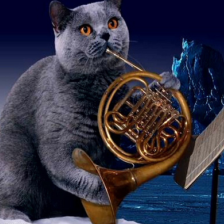

In [14]:
from torchvision.transforms import ToPILImage
to_img = ToPILImage()
to_img(images[0])

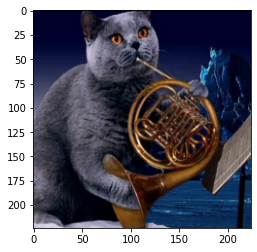

In [15]:
# Alternatively

import matplotlib.pyplot as plt
%matplotlib inline
img = images.numpy()[0]
img = np.transpose(img, (1,2,0))
plt.imshow(img)
plt.show()

## Set up "Activation Microscope"

Next, we set up code to read off the pre-ReLU activations of the BW vs color detector channels in layer mixed3a as we run various inputs through the model.

In [16]:
class SaveFeatures():
    features = None
    def __init__(self, model):
        for name, module in model.named_modules():
            if name == 'mixed3a_5x5_pre_relu_conv':
                self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output 
    def close(self):
        self.hook.remove()

An example of this class at work:

In [17]:
activations = SaveFeatures(model)
out = model(images)    
activations.close()
activations.features[0,5].mean().item()

1.3695734739303589

# Activations across ImageNet

In [18]:
activations = np.zeros((9, 950002))

In [ ]:
# This cell takes about 1 day to run on my laptop.

for i, data in enumerate(trainloader):
    images, labels = data
    probe = SaveFeatures(model)
    out = model(images)
    probe.close()
    activations[0,i] = probe.features[0,5].mean().item()
    activations[1,i] = probe.features[0,9].mean().item()
    activations[2,i] = probe.features[0,12].mean().item()
    activations[3,i] = probe.features[0,16].mean().item()
    activations[4,i] = probe.features[0,18].mean().item()
    activations[5,i] = probe.features[0,22].mean().item()
    activations[6,i] = probe.features[0,28].mean().item()
    activations[7,i] = probe.features[0,30].mean().item()
    activations[8,i] = probe.features[0,31].mean().item()
    if i % 10000 == 0: 
        print(i)

In [ ]:
np.save('activations.npy', activations)

In [26]:
# In the future, just run this cell instead [from the correct directory]:
activations = np.load('activations.npy')

As a sanity check that we did this right, let's check that the first image that the pure BW detector channel, mixed3a:222 activates strongly on is one that we would expect it to activate strongly on.

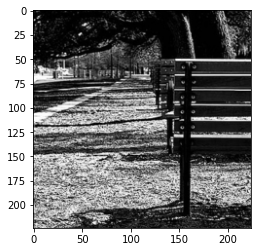

In [31]:
for i, data in enumerate(trainloader):
    images, labels = data
    probe = SaveFeatures(model)
    out = model(images)
    probe.close()
    if probe.features[0,30].mean().item() > 50:
        img = images.numpy()[0]
        img = np.transpose(img, (1,2,0))
        plt.imshow(img)
        plt.show() 
        break

Looks good! So let's make the plot.

In [34]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15, 6)})

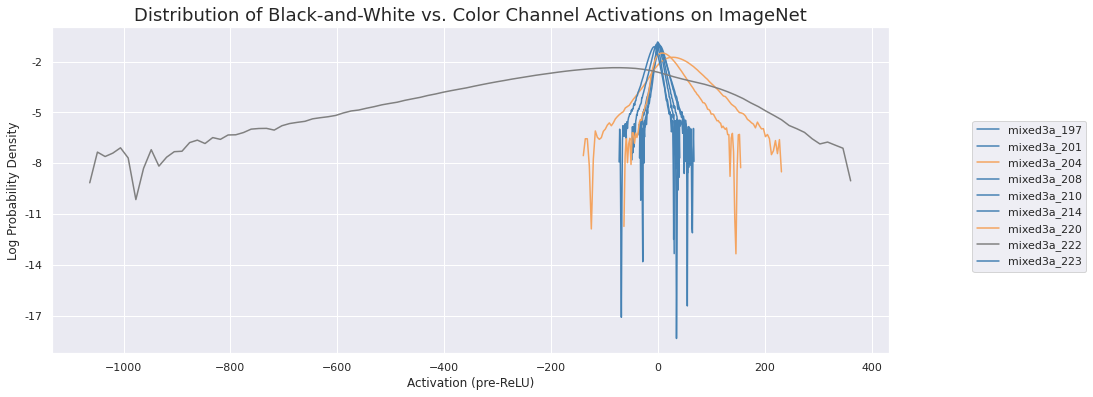

In [35]:
p1 = sns.kdeplot(activations[0], clip=(-36,60), label = 'mixed3a_197', color='steelblue')
p1 = sns.kdeplot(activations[1], label = 'mixed3a_201', color='steelblue')
p1 = sns.kdeplot(activations[2], clip=(-140, 300), label = 'mixed3a_204', color='sandybrown')
p1 = sns.kdeplot(activations[3], label = 'mixed3a_208', color='steelblue')
p1 = sns.kdeplot(activations[4], label = 'mixed3a_210', color='steelblue')
p1 = sns.kdeplot(activations[5], clip=(-36, 80), label = 'mixed3a_214', color='steelblue')
p1 = sns.kdeplot(activations[6], clip=(-64, 200), label = 'mixed3a_220', color='sandybrown')
p1 = sns.kdeplot(activations[7], label = 'mixed3a_222', color='gray')
p1 = sns.kdeplot(activations[8], clip=(-100,30), label = 'mixed3a_223', color='steelblue')
p1.set_title('Distribution of Black-and-White vs. Color Channel Activations on ImageNet', fontsize=18)
p1.set_xlabel('Activation (pre-ReLU)')
p1.set_ylabel('Log Probability Density')
p1.set_yscale("log")
p1.set_yticklabels(['blank', 'blank', '-17', '-14', '-11', '-8', '-5', '-2'])
p1.legend(loc=(1.10, 0.25))

## Synthetic Data

In this section, we plot the distribution of the pure BW detector channel activation on (a subset of) ImageNet images vs. on those images converted to grayscale. This can be done by averaging over the RGB channels.

Recall that ImageNet images are tensors of shape (1,3,224,224).

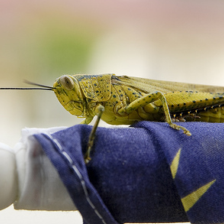

In [45]:
images, labels = dataiter.next()
to_img = ToPILImage()
to_img(images[0])

So we can make them black and white as follows.

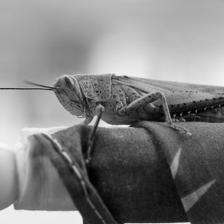

In [48]:
imagebw = images.mean(1).unsqueeze(1).repeat(1,3,1,1)
to_img(imagebw[0])

Given this, we can record the mean channel activations of mixed3a:222 (and the other BW vs color detector channels) on 10k ImageNet images vs. those images converted to grayscale as follows.

In [49]:
bwactivations = np.zeros((18, 10000))

In [50]:
for i, data in enumerate(trainloader):
    images, labels = data
    probe = SaveFeatures(model)
    out = model(images)
    probe.close()
    bwactivations[0,i] = probe.features[0,5].mean().item()
    bwactivations[1,i] = probe.features[0,9].mean().item()
    bwactivations[2,i] = probe.features[0,12].mean().item()
    bwactivations[3,i] = probe.features[0,16].mean().item()
    bwactivations[4,i] = probe.features[0,18].mean().item()
    bwactivations[5,i] = probe.features[0,22].mean().item()
    bwactivations[6,i] = probe.features[0,28].mean().item()
    bwactivations[7,i] = probe.features[0,30].mean().item()
    bwactivations[8,i] = probe.features[0,31].mean().item()
    probe = SaveFeatures(model)
    out = model(images.mean(1).unsqueeze(1).repeat(1,3,1,1))
    probe.close()
    bwactivations[9,i] = probe.features[0,5].mean().item()
    bwactivations[10,i] = probe.features[0,9].mean().item()
    bwactivations[11,i] = probe.features[0,12].mean().item()
    bwactivations[12,i] = probe.features[0,16].mean().item()
    bwactivations[13,i] = probe.features[0,18].mean().item()
    bwactivations[14,i] = probe.features[0,22].mean().item()
    bwactivations[15,i] = probe.features[0,28].mean().item()
    bwactivations[16,i] = probe.features[0,30].mean().item()
    bwactivations[17,i] = probe.features[0,31].mean().item()
    if i % 1000 == 0: 
       print(i)
    if i == 9999:
        break

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


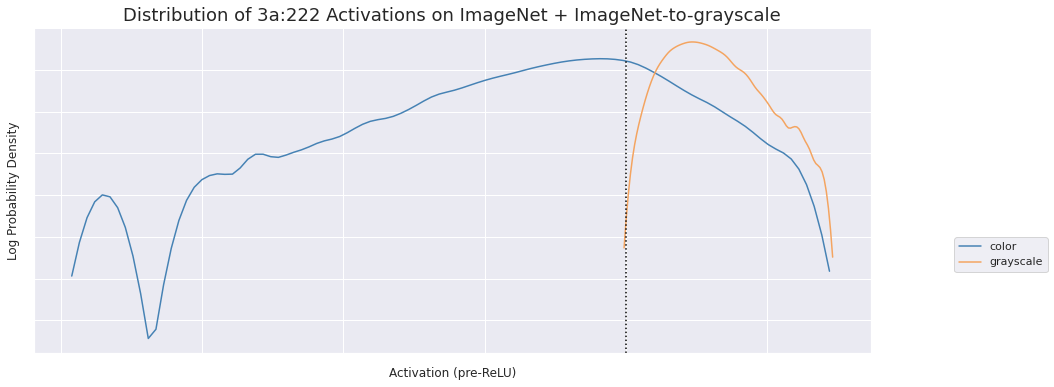

In [53]:
p1 = sns.kdeplot(bwactivations[7], label='color', color='steelblue')
p1 = sns.kdeplot(bwactivations[16],label='grayscale', color='sandybrown')
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('Distribution of 3a:222 Activations on ImageNet + ImageNet-to-grayscale', fontsize=18)
p1.set_xlabel('Activation (pre-ReLU)')
p1.set_ylabel('Log Probability Density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1.legend(loc=(1.10, 0.25))

(This plot is slightly different from the one in the draft because I ran it on a different random draw of 10k images, but qualitatively the same).

As a bonus, we can also record the activations of the other BW vs color detector channels on this dataset.

[]

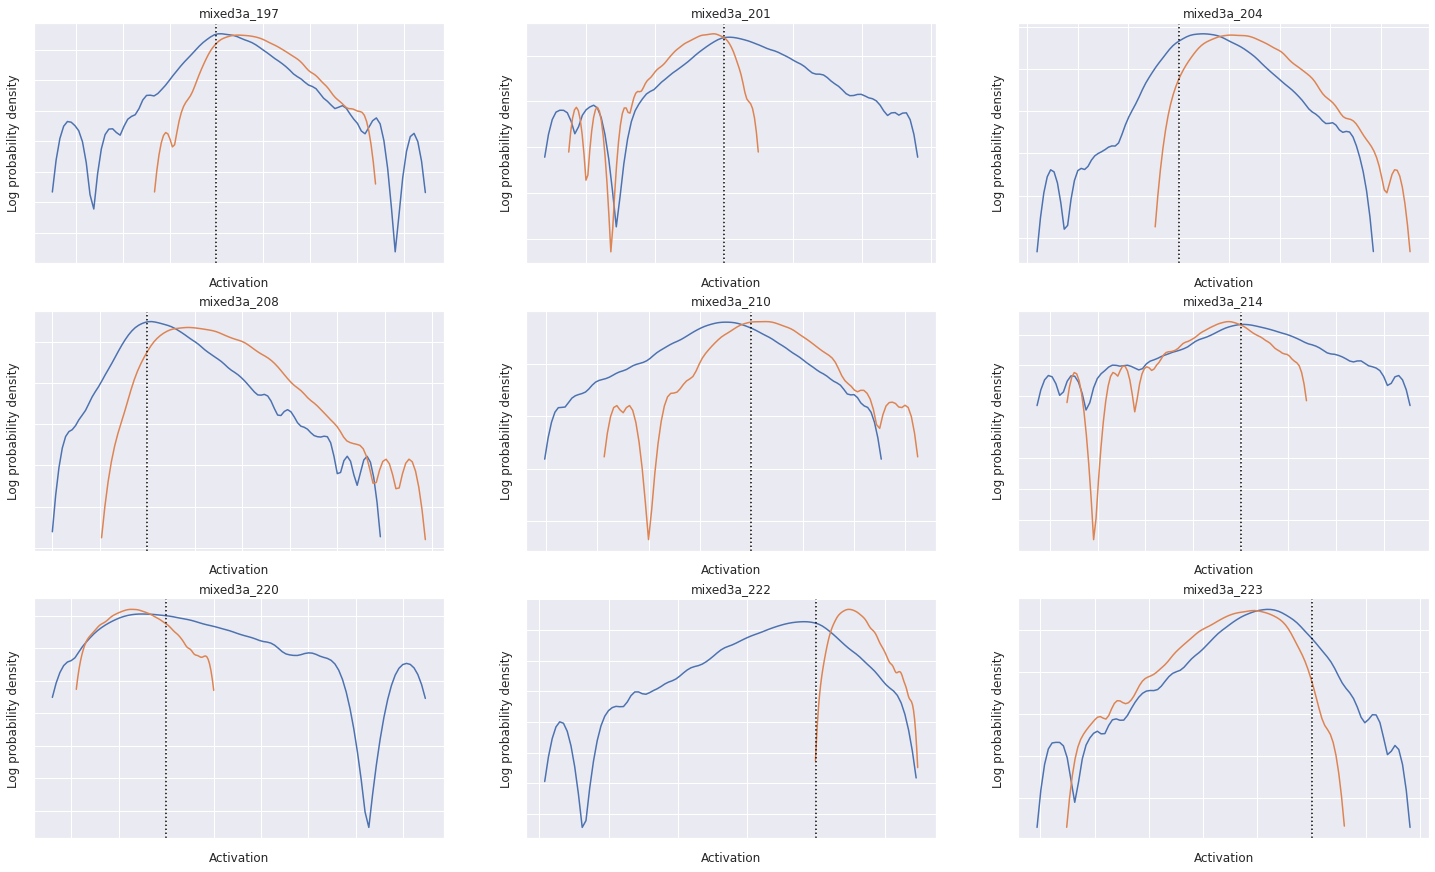

In [55]:
f, axes = plt.subplots(3,3, figsize=(25, 15))

p1 = sns.kdeplot(bwactivations[0], ax=axes[0,0])
p1 = sns.kdeplot(bwactivations[9], ax=axes[0,0])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_197')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[1], ax=axes[0,1])
p1 = sns.kdeplot(bwactivations[10], ax=axes[0,1])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_201')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[2], ax=axes[0,2])
p1 = sns.kdeplot(bwactivations[11], ax=axes[0,2])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_204')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
#p1.legend(loc=(1.05, 0.5))
p1 = sns.kdeplot(bwactivations[3], ax=axes[1,0])
p1 = sns.kdeplot(bwactivations[12], ax=axes[1,0])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_208')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[4], ax=axes[1,1])
p1 = sns.kdeplot(bwactivations[13], ax=axes[1,1])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_210')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[5], ax=axes[1,2])
p1 = sns.kdeplot(bwactivations[14], ax=axes[1,2])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_214')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[6], ax=axes[2,0])
p1 = sns.kdeplot(bwactivations[15], ax=axes[2,0])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_220')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[7], ax=axes[2,1])
p1 = sns.kdeplot(bwactivations[16], ax=axes[2,1])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_222')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])
p1 = sns.kdeplot(bwactivations[8], ax=axes[2,2])
p1 = sns.kdeplot(bwactivations[17], ax=axes[2,2])
p1.axvline(0, color='black', linestyle='dotted')
p1.set_title('mixed3a_223')
p1.set_xlabel('Activation')
p1.set_ylabel('Log probability density')
p1.set_yscale("log")
p1.set_xticklabels([])
p1.set_yticklabels([])

The rest of them don't do anything as interesting on this experiment, as we would expect (although mixed3a:204, which seems to be *almost* a BW detector from its feature visualization, shifts to *almost* positive activations!).